In [2]:
print('Hello, World!')

Hello, World!


In [2]:
!nvidia-smi 
!which python

Fri Feb 16 01:30:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   62C    P8               6W /  50W |    748MiB /  4096MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

'which' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from ultralytics import YOLO
import cv2 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def calculate_percent_in_mask(image, mask):
    
    '''
    Parameters:
    image: The image to be analyzed. np.array
    mask: The mask to be applied to the image. np.array 

    Output:
    red_color_percent: The percentage of red pixels in the specified mask. float
    green_color_percent: The percentage of green pixels in the specified mask. float
    mean_val_np: The mean value of each channel in the specified mask. np.array

    '''
    
    # Convert color to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # Calculate the mean value for each channel within the specified mask
    mean_val = cv2.mean(img_hsv, mask=mask)

    # Convert the mean values to a NumPy array
    mean_val_np = np.array(mean_val)

    # Define the target color range in HSV
    # Red mask1 (0-15)
    lower_red = np.array([0, 40, 50])
    upper_red = np.array([15, 255, 255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)
    # dark red mask2
    lower_red = np.array([160, 40, 50])
    upper_red = np.array([180, 255, 255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)
    # Join two masks
    maskRed = mask0 + mask1

    # yellow-green mask
    lower_green = np.array([20,40,50])
    upper_green = np.array([80,255,255])
    maskGreen = cv2.inRange(img_hsv, lower_green, upper_green)

    # Ensure the mask is single-channel (grayscale)
    if len(maskRed.shape) > 2:
        maskRed = cv2.cvtColor(maskRed, cv2.COLOR_BGR2GRAY)

    # Calculate the ratio of red pixels in the specified mask
    ratio_red = cv2.countNonZero(maskRed) / cv2.countNonZero(mask)
    ratio_green = cv2.countNonZero(maskGreen) / cv2.countNonZero(mask)

    # Calculate the color percentage
    red_color_percent = ratio_red * 100
    green_color_percent = ratio_green * 100
    # Round the color_percent to two decimal places
    red_color_percent = np.round(red_color_percent, 2)
    green_color_percent = np.round(green_color_percent, 2)

    return red_color_percent, green_color_percent, mean_val_np, maskRed, maskGreen


In [5]:
def find_ripness(red_color_percent, green_color_percent):
    '''
    Parameters:
    red_color_percent: The percentage of red pixels in the specified mask of the starberry. float
    green_color_percent: The percentage of green pixels in the specified mask of the starberry. float

    Output:
    ripeness: The ripeness of the fruit that have 5 class (full_ripe, ripe, medium_ripe, half_ripe, unripe). str

    '''

    # Define the ripeness of the fruit
    if green_color_percent >= 50 or red_color_percent < 50:
        return 'unripe'
    elif red_color_percent >= 90 and green_color_percent < 10:
        return 'full_ripe'
    elif 70 <= red_color_percent < 90 and green_color_percent < 20:
        return 'ripe'
    elif 60 <= red_color_percent < 70 and green_color_percent < 30:
        return 'medium_ripe'
    elif 50 <= red_color_percent < 60 and green_color_percent < 40:
        return 'small_ripe'
    else:
        return 'unknown'

In [ ]:
%pip install protobuf==3.20.1

# Read Single Image

In [6]:
img_path = './images/'
model_path = 'models/yolov8n/'


model = YOLO(model_path+'best.pt', task='segment')
image = cv2.imread(img_path + '8.png')


class_name = model.names
print('class_name: ', class_name)

results = model(image, conf=0.9)

class_name:  {0: 'strawberry'}



0: 480x640 3 strawberrys, 81.0ms
Speed: 5.0ms preprocess, 81.0ms inference, 76.0ms postprocess per image at shape (1, 3, 480, 640)


In [6]:
for result in results:
    img = result.orig_img
    for ci, c in enumerate(result):
        label = c.names[c.boxes.cls.tolist().pop()]
        # Create binary mask
        b_mask = np.zeros(img.shape[:2], np.uint8)

        #  Extract contour result
        contour = c.masks.xy.pop()
        #  Changing the type
        contour = contour.astype(np.int32)
        #  Reshaping
        contour = contour.reshape(-1, 1, 2)

        # Draw contour onto mask
        _ = cv2.drawContours(b_mask,
                            [contour],
                            -1,
                            (255, 255, 255),
                            cv2.FILLED)
        
        # Create 3-channel mask
        mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)

        # Isolate object with binary mask
        isolated = cv2.bitwise_and(mask3ch, img)
        cv2.imwrite(f'isolated_image{ci}', isolated)
        #  Bounding box coordinates
        x1, y1, x2, y2 = c.boxes.xyxy.cpu().numpy().squeeze().astype(np.int32)  
        
        # Crop image to object region
        iso_crop = isolated[y1:y2, x1:x2]
        mask_crop = mask3ch[y1:y2, x1:x2]
        red_color_percent, green_color_percent, mean_val, mask_red, mask_green = calculate_percent_in_mask(iso_crop, mask_crop)
        ripeness = find_ripness(red_color_percent, green_color_percent) 


        # Plot the images
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the original image
        axes[0].imshow(cv2.cvtColor(mask_red, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'Red Mask Image')

                # Plot the mask on top of the original image
        axes[1].imshow(cv2.cvtColor(mask_green, cv2.COLOR_BGR2RGB))  # Set alpha to control transparency
        axes[1].set_title(f'Green Mask Mask')
        



NameError: name 'results' is not defined

# Read Mutiple Image

In [8]:
import os

BASE_PATH = "./ripness/"
def save_image(image, ripness):
    save_folder = os.path.join(BASE_PATH, ripness)
    
    # Create the folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Save the image
    index = len(os.listdir(save_folder))
    cv2.imwrite(os.path.join(save_folder, f"{index}.png"), image)
    


In [22]:
model_path = "models/yolov8n/"
model = YOLO(model_path+"best.pt", task="segment")
source = "dataset/Strawberry (2)/test/images/*.jpg"

results = model(source, conf=0.5, stream=True, device=0)

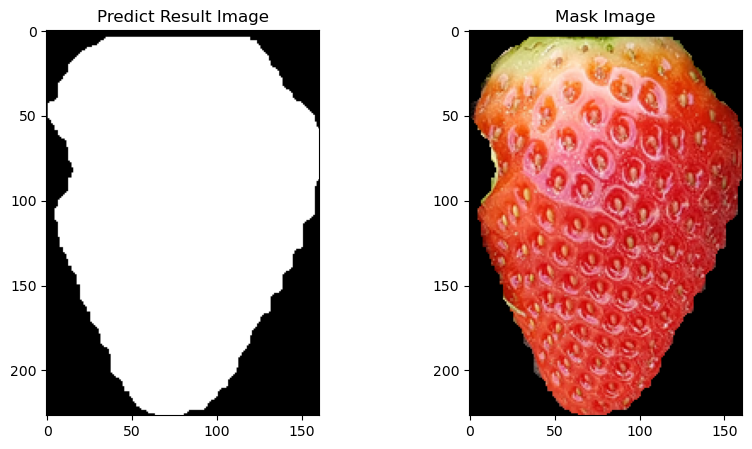

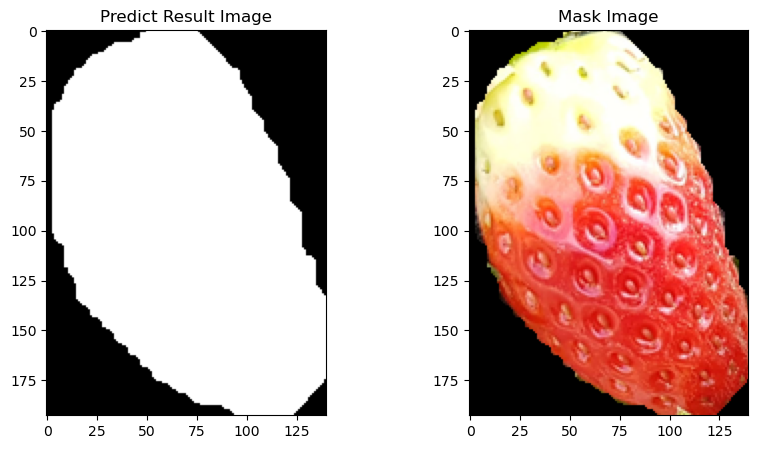

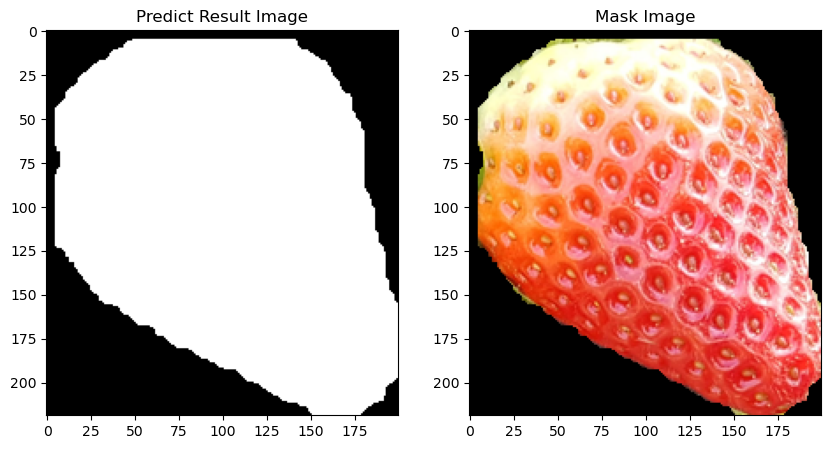

In [12]:
for result in results:
    img = result.orig_img
    for ci, c in enumerate(result):
        label = c.names[c.boxes.cls.tolist().pop()]
        # Create binary mask
        b_mask = np.zeros(img.shape[:2], np.uint8)

        #  Extract contour result
        contour = c.masks.xy.pop()
        #  Changing the type
        contour = contour.astype(np.int32)
        #  Reshaping
        contour = contour.reshape(-1, 1, 2)

        # Draw contour onto mask
        _ = cv2.drawContours(b_mask,
                            [contour],
                            -1,
                            (255, 255, 255),
                            cv2.FILLED)
        
        # Create 3-channel mask
        mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)

        # Isolate object with binary mask
        isolated = cv2.bitwise_and(mask3ch, img)
        #  Bounding box coordinates
        x1, y1, x2, y2 = c.boxes.xyxy.cpu().numpy().squeeze().astype(np.int32)  
        
        # Crop image to object region
        iso_crop = isolated[y1:y2, x1:x2]
        mask_crop = mask3ch[y1:y2, x1:x2]
        red_color_percent, green_color_percent, mean_val, mask_red, mask_green = calculate_percent_in_mask(iso_crop, mask_crop)
        ripeness = find_ripness(red_color_percent, green_color_percent) 

        # Plot the images
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the original image
        axes[0].imshow(cv2.cvtColor(mask_crop, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'ROI Mask Image')

        # Plot the original image
        axes[1].imshow(cv2.cvtColor(iso_crop, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'ROI Crop Image')


In [21]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('models/yolov8n/best.pt', task='segment')

# Define source as YouTube video URL
source = 'https://youtu.be/qfjlxInN1Bc?si=8G9kh-z3qli3BU-c&t=443'

# Run inference on the source
results = model(source, stream=True)  # generator of Results objects
